## **Importar las librerias necesarias**

In [1]:
import tensorflow as tf                                      # tensorflow==2.10.0  
import numpy as np                                           # numpy==1.26.4
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as kp_image
import matplotlib.pyplot as plt                              # matplotlib==3.9.2
import os

## **Ajustes de pesos de Contenido, Estilo y Textura**

In [2]:
content_weight = 1e1
style_weight = 1e3
texture_weight = 1e-4  

## **Desglose de la función load_and_process_image**

Esta función se encarga de cargar una imagen desde una ruta específica y prepararla para ser usada en el modelo de neural style transfer. En este caso, se utiliza la biblioteca tensorflow.keras.preprocessing para cargar y procesar la imagen, y el modelo VGG19 para estandarizar la imagen antes de pasarla por la red neuronal.

In [3]:
def load_and_process_image(img_path):
    img = kp_image.load_img(img_path, target_size=(512, 512))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

**target_size=(512, 512)** asegura que todas las imágenes se escalen a una resolución de 512x512 píxeles. Esto estandariza el tamaño para que las entradas al modelo sean uniformes, facilitando los cálculos y asegurando que las capas convolucionales reciban entradas de tamaño compatible.


**kp_image.img_to_array** convierte la imagen cargada en un arreglo de tipo numpy. Esto permite manipular cada valor de los píxeles (canales RGB) individualmente.

**np.expand_dims(img, axis=0)** añade una nueva dimensión al arreglo, que representa el lote de imágenes (batch size). Esto es necesario porque los modelos de aprendizaje profundo en TensorFlow suelen procesar lotes de datos, y al agregar esta dimensión, la imagen se adapta al formato esperado por el modelo VGG19.

**vgg19.preprocess_input** aplica una serie de transformaciones a la imagen para que esté en el mismo rango y formato que las imágenes utilizadas para entrenar el modelo VGG19. Esto normalmente implica centrar los valores de los píxeles alrededor de cero y aplicar una normalización específica.

**tf.convert_to_tensor** convierte el arreglo numpy en un tensor TensorFlow, con tipo de dato tf.float32. Los tensores son el formato que usa TensorFlow para representar los datos durante las operaciones de la red neuronal.

## **Desglose de la función deprocess_image**

Convierte la imagen preprocesada nuevamente a un formato visualizable.

In [4]:
# Función para desprocesar imágenes (para visualización)
def deprocess_image(processed_img):
    x = processed_img.copy()
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

**processed_img.copy()** genera una copia de la imagen procesada

Aquí, sumamos valores específicos para cada canal de color (R, G, B), que son las mismas constantes utilizadas en el preprocesamiento del modelo VGG19:  
Canal Rojo (R): se suma 103.939.  
Canal Verde (G): se suma 116.779.  
Canal Azul (B): se suma 123.68.  

**np.clip(x, 0, 255)** limita los valores de los píxeles entre 0 y 255, que es el rango estándar para visualizar imágenes en pantalla.

## **Desglose de la función get_model**

Construye el modelo y selecciona las capas de estilo y contenido en el modelo VGG19 para el neural style transfer.

In [5]:
# Función para construir el modelo y seleccionar las capas de estilo y contenido
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layers = ['block5_conv2']
    model_outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    return tf.keras.Model(vgg.input, model_outputs), style_layers, content_layers

**vgg19.VGG19(include_top=False, weights='imagenet')** carga el modelo VGG19 preentrenado en el dataset ImageNet, sin incluir la parte superior (capa de clasificación). 

**vgg.trainable = False** asegura que el modelo VGG19 no se actualice durante el proceso de optimización del estilo y contenido.

**style_layers** define las capas convolucionales que capturan las características de estilo de la imagen. 

**content_layers** define la capa de contenido

**vgg.get_layer(name).output** selecciona la salida de cada capa de estilo y contenido definida previamente.

**model_outputs** almacena las representaciones de estilo y contenido en un solo arreglo.

**tf.keras.Model(vgg.input, model_outputs)** crea un nuevo modelo que toma como entrada la imagen original y devuelve las representaciones de estilo y contenido.

## **Desglose de la función content_loss**

Calcula la pérdida de contenido

In [6]:
# Función para calcular la pérdida de contenido
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

**base_content** y **target** son las representaciones de contenido extraídas de la capa de contenido (por ejemplo, block5_conv2) para la imagen generada y la imagen de contenido, respectivamente.

**tf.square** eleva al cuadrado cada elemento de la diferencia.

**tf.reduce_mean** toma el promedio de los valores del error cuadrático medio, generando un único valor escalar que representa la pérdida de contenido.

## **Desglose de la función gram_matrix**

Calcula la matriz de Gram de un tensor de entrada

In [7]:
# Función para calcular la pérdida de estilo
def gram_matrix(input_tensor):
    # Asegura que input_tensor tiene 4 dimensiones
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)

    # Calcula la matriz de Gram
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


**tf.expand_dims(input_tensor, axis=0)** añade una dimensión de lote si input_tensor tiene solo tres dimensiones (height, width, channels).

**tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)** utiliza el producto de Einstein (einstein summation) para calcular la matriz de Gram.

**input_shape = tf.shape(input_tensor)** obtiene las dimensiones de input_tensor, y **num_locations** calcula el número total de ubicaciones espaciales multiplicando las dimensiones de altura y ancho (height * width).

## **Desglose de la función style_loss**

Calcula la pérdida de estilo

In [8]:
def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

**gram_matrix(base_style)** calcula la matriz de Gram para base_style, que es la representación de estilo de la imagen generada en una capa específica.

## **Cargar y procesar las imágenes**


Configura las rutas de las imágenes de contenido y estilo y las carga utilizando la función **load_and_process_image**

In [9]:
base_dir = os.getcwd() 
content_image_path =  os.path.join(base_dir, 'Contenido_2.jpg')  # Imagen de contenido
style_image_path = os.path.join(base_dir, 'Estilo_2.jpg')       # Imagen de estilo
content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

## **Cargar el modelo, obtener las capas de contenido y estilo, y obtener las caracteristicas**

Extrae las características de estilo y contenido de las imágenes procesadas usando un modelo VGG19 modificado.

In [10]:
model, style_layers, content_layers = get_model()

# Extraer las características de estilo de la imagen de estilo
style_outputs = model(style_image)
style_features = [style_layer for style_layer in style_outputs[:len(style_layers)]]

# Extraer las características de contenido de la imagen de contenido
content_outputs = model(content_image)
content_features = [content_layer for content_layer in content_outputs[len(style_layers):]]

## **Configura la imagen inicial y el optimizador**

Inicializa la imagen generada y configura el optimizador para el proceso de neural style transfer.

In [11]:
init_image = tf.Variable(content_image, dtype=tf.float32)
opt = optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

## **Desglose de la función compute_loss_and_grads**

Calcula las pérdidas (de estilo y contenido) y sus gradientes con respecto a la imagen generada.

In [12]:
def compute_loss_and_grads(cfg):
    with tf.GradientTape() as tape:
        model_outputs = cfg['model'](cfg['init_image'])
        
        # Separar características de estilo y contenido
        style_output_features = model_outputs[:len(cfg['style_features'])]
        content_output_features = model_outputs[len(cfg['style_features']):]
        
        # Pérdida de estilo
        style_score = 0
        for target_style, comb_style in zip(cfg['style_features'], style_output_features):
            style_score += style_loss(comb_style[0], gram_matrix(target_style))
        style_score *= style_weight
        
        # Pérdida de contenido
        content_score = 0
        for target_content, comb_content in zip(cfg['content_features'], content_output_features):
            content_score += content_loss(comb_content[0], target_content)
        content_score *= content_weight
        
        # Pérdida total
        total_loss = style_score + content_score
    grads = tape.gradient(total_loss, cfg['init_image'])
    return grads, total_loss

**tf.GradientTape** es un contexto en el que TensorFlow realiza un seguimiento de las operaciones para calcular los gradientes más tarde.

**cfg['model'](cfg['init_image'])** pasa la imagen generada **(cfg['init_image'])** a través del modelo preentrenado VGG19 (o el modelo definido en **cfg['model'])**.

**style_output_features** contiene las activaciones de las capas de estilo, que están al principio de la lista model_outputs.

**content_output_features** contiene las activaciones de las capas de contenido, que siguen después de las de estilo en model_outputs.

Se inicializa style_score en 0.  

Luego, se itera sobre las características de estilo de la imagen de estilo (cfg['style_features']) y las activaciones de estilo obtenidas del modelo (style_output_features).  

Para cada par de características de estilo, se calcula la pérdida de estilo usando la función style_loss entre las activaciones de estilo de la imagen generada (comb_style[0]) y la matriz de Gram de las características de estilo de la imagen de estilo (gram_matrix(target_style)).  

Finalmente, se multiplica la pérdida de estilo por el peso de estilo (style_weight), que controla la importancia relativa de la pérdida de estilo en comparación con la pérdida de contenido.  

Se inicializa content_score en 0.  

Luego, se itera sobre las características de contenido de la imagen de contenido (cfg['content_features']) y las activaciones de contenido obtenidas del modelo (content_output_features).  

Para cada par de características de contenido, se calcula la pérdida de contenido usando la función content_loss entre las activaciones de contenido de la imagen generada (comb_content[0]) y las activaciones de contenido de la imagen de contenido (target_content).  

Luego, la pérdida de contenido se multiplica por el peso de contenido (content_weight), que determina la importancia de la pérdida de contenido en el proceso de optimización.


**total_loss** la pérdida total es la suma de la pérdida de estilo (style_score) y la pérdida de contenido (content_score).

**tape.gradient(total_loss, cfg['init_image'])** calcula los gradientes de la pérdida total con respecto a la imagen generada (cfg['init_image']).

## **Configuración del diccionario de características y pesos**

Crea un diccionario cfg que contiene todos los parámetros necesarios para el cálculo de la pérdida y los gradientes en el proceso de optimización del neural style transfer.

In [ ]:
cfg = {
    'model': model,
    'loss_weights': (content_weight, style_weight, texture_weight),
    'init_image': init_image,
    'content_features': content_features,
    'style_features': style_features
}

: 

## **Desglose de ejecución del código**

Lleva a cabo el proceso de optimización para el neural style transfer. A través de varias iteraciones, la imagen generada (init_image) se va ajustando para minimizar las pérdidas de estilo y contenido, usando los gradientes calculados previamente. 

In [ ]:
# Número de iteraciones de optimización
num_iterations = 1900

for i in range(num_iterations):
    grads, all_loss = compute_loss_and_grads(cfg)
    opt.apply_gradients([(grads, init_image)])
    
    # Mostrar el progreso de la pérdida
    if i % 100 == 0:
        print(f"Iteration {i}: Loss: {all_loss}")
    if i % 300 == 0:
        # Convertir la imagen resultante para visualización
        final_img = deprocess_image(init_image.numpy()[0])
        plt.imshow(final_img)
        plt.axis('off')
        plt.show()

Iteration 0: Loss: 607509299593216.0


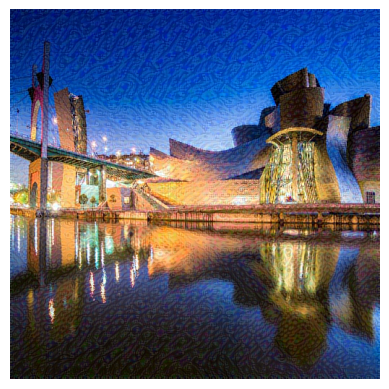

In [ ]:
final_img = deprocess_image(init_image.numpy()[0])
plt.imshow(final_img)
plt.axis('off')
plt.show()